<img width="10%" alt="Naas" src="https://landen.imgix.net/jtci2pxwjczr/assets/5ice39g4.png?w=160"/>


# LinkedIn - Follow profile content engagement rate monthly
<a href="https://app.naas.ai/user-redirect/naas/downloader?url=https://raw.githubusercontent.com/jupyter-naas/awesome-notebooks/master/LinkedIn/Linkedin_Follow_number_of_content_published.ipynb" target="_parent"><img src="https://naasai-public.s3.eu-west-3.amazonaws.com/open_in_naas.svg"/></a>

**Tags:** #linkedin #html #plotly #csv #image #content #analytics #automation

**Author:** [Florent Ravenel](https://www.linkedin.com/in/florent-ravenel/)

This notebook follows the evolution of content engagement rate (likes +  comments) / views) on LinkedIn.

## Input

In [1]:
# Except allow to run common.ipynb once using Naas Engine
try:
    %run "../common.ipynb"
except:
    %run "common.ipynb"

### Setup Variables

In [6]:
# Inputs
KPI_TITLE = "Engagement rate"
INPUT_DATABASE = LK_PROFILE_POSTS
PLATFORM = LINKEDIN
LOGO = LINKEDIN_LOGO
COLOR = LINKEDIN_COLOR
OWNER = LK_FULLNAME
OWNER_ID = LK_PROFILE_ID
COL_VALUE = KPI_TITLE.upper().replace(' ', '_')

### Setup Constants

In [7]:
PERIOD = PERIOD_MTD
PERIOD_D = DISPLAY_MTD
PERIOD_TEXT = TEXT_MTD
PERIOD_TEXT2 = TEXT2_MTD
SCENARIO = SCENARIO_MTD
TITLE = f"Content {KPI_TITLE.lower()} over the past {str(MONTH_ROLLING)} {PERIOD_TEXT2}"

# Outputs
name_output = f"LINKEDIN_FOLLOW_PROFILE_{KPI_TITLE.upper().replace(' ', '_')}_{SCENARIO}_{OWNER_ID}"
csv_output = path.join(LINKEDIN_OUTPUTS, f"{name_output}.csv")
html_output = path.join(LINKEDIN_OUTPUTS, f"{name_output}.html")
image_output = path.join(LINKEDIN_OUTPUTS, f"{name_output}.png")

## Model

### Get your posts

In [4]:
df_posts = get_data(INPUT_DATABASE)
print("✅ Posts fetched:", len(df_posts))
df_posts.head(1)

✅ Posts fetched: 23


,ACTIVITY_ID,PAGINATION_TOKEN,PUBLISHED_DATE,AUTHOR_NAME,AUTHOR_URL,SUBDESCRIPTION,TITLE,TEXT,CHARACTER_COUNT,TAGS,...,POLL_ID,POLL_QUESTION,POLL_RESULTS,POST_URL,VIEWS,COMMENTS,LIKES,SHARES,ENGAGEMENT_SCORE,DATE_EXTRACT
0,6948301377668317184,dXJuOmxpOmFjdGl2aXR5OjY5NDgzMDEzNzc2NjgzMTcxOD...,2022-06-30 15:49:01+02:00,Florent Ravenel,https://www.linkedin.com/in/ACoAABCNSioBW3YZHc...,22 hours ago,🪄 Use Jupyter notebooks to building up data pi...,🪄 Use Jupyter notebooks to building up data pi...,1040,#naaslife #opensource #buildinpublic #datascie...,...,NaN,NaN,NaN,https://www.linkedin.com/feed/update/urn:li:ac...,3313,3,34,0,0.0112,2022-07-01 16:33:17


### Get dataframe trend

In [9]:
def get_trend(df_init,
              col_date,
              col_value,
              agg_value):
    # Init variable
    df = df_init.copy()
    
    # Groupby period
    df["ENGAGEMENTS"] = df["LIKES"].astype(int) + df["COMMENTS"].astype(int)  + df["SHARES"].astype(int)
    df["VIEWS"] = df["VIEWS"].astype(int)
    df[col_date] = pd.to_datetime(df[col_date].str[:-6]).dt.strftime(PERIOD)
    df = df.groupby(col_date, as_index=False).agg({"ENGAGEMENTS": agg_value, "VIEWS": agg_value})
    
    # Rename column
    to_rename = {
        col_date: "DATE_ISO",
    }
    df = df.rename(columns=to_rename)
    
    # Reindex value
    d = datetime.now().date()
    d2 = df.loc[df.index[0], "DATE_ISO"]
    idx = pd.date_range(d2, d, freq = "D")    
    df.set_index("DATE_ISO", drop=True, inplace=True)
    df.index = pd.DatetimeIndex(df.index)
    df = df.reindex(idx, fill_value=0)
    df["DATE_ISO"] = pd.DatetimeIndex(df.index)
    
    # Groupby month
    df["DATE"] = pd.to_datetime(df["DATE_ISO"], format=DATE_FORMAT).dt.strftime(PERIOD)
    # Plotly: Date display
    df["DATE_D"] = pd.to_datetime(df["DATE_ISO"], format=DATE_FORMAT).dt.strftime(PERIOD_D)
    df = df.groupby(["DATE", "DATE_D"], as_index=False).agg({"ENGAGEMENTS": agg_value, "VIEWS": agg_value})
    df["VALUE"] = df["ENGAGEMENTS"].astype(int) / df["VIEWS"].astype(int)

    # Calc variation
    for index, row in df.iterrows():
        if index > 0:
            n = df.loc[df.index[index], "VALUE"]
            n_1 = df.loc[df.index[index-1], "VALUE"]
            df.loc[df.index[index], "VALUE_COMP"] = n_1
            df.loc[df.index[index], "VARV"] = n - n_1
            if n_1 > 0:
                df.loc[df.index[index], "VARP"] = (n - n_1) / abs(n_1)
    df = df.fillna(0)
    
    # Plotly: Date display
    df["DATE_D"] = pd.to_datetime(df["DATE"], format=PERIOD).dt.strftime(PERIOD_D)
    
    # Plotly: Value display
    df["VALUE_D"] = "<b><span style=font-size: 16px; style=font-family: Arial>" + df["VALUE"].map("{:,.2%}".format).str.replace(",", " ") + "</span></b>"
    
    # Plotly: Variation display
    df["VARV_D"] = (df["VARV"] * 100).map("{:,.2f} pts".format).str.replace(",", " ")
    df.loc[df["VARV"] >= 0, "VARV_D"] = "+" + df["VARV_D"]
    df["VARP_D"] = df["VARP"].map("{:,.0%}".format).str.replace(",", " ")
    df.loc[df["VARP"] >= 0, "VARP_D"] = "+" + df["VARP_D"]
    
    # Plotly: hovertext
    df["TEXT"] = ("<b><span style='font-size: 14px;'>" + df["DATE_D"].astype(str) + ": " + df["VALUE_D"] + "</span></b><br>"
                  "<span style='font-size: 12px;'>" + f"{PERIOD_TEXT}: " + df["VARV_D"] + " (" + df["VARP_D"] + ")</span>")
    
    # Return month rolling
    return df[-MONTH_ROLLING:].reset_index(drop=True)

df_actual = get_trend(df_posts,
                      col_date="PUBLISHED_DATE",
                      col_value=COL_VALUE,
                      agg_value="sum")
df_actual#.tail(5)

,DATE,DATE_D,ENGAGEMENTS,VIEWS,VALUE,VALUE_COMP,VARV,VARP,VALUE_D,VARV_D,VARP_D,TEXT
0,2021-08,Aug 2021,0,0,0.000000,0.000000,0.000000,0.000000,<b><span style=font-size: 16px; style=font-fam...,+0.00 pts,+0%,<b><span style='font-size: 14px;'>Aug 2021: <b...
1,2021-09,Sep 2021,0,0,0.000000,0.000000,0.000000,0.000000,<b><span style=font-size: 16px; style=font-fam...,+0.00 pts,+0%,<b><span style='font-size: 14px;'>Sep 2021: <b...
2,2021-10,Oct 2021,0,0,0.000000,0.000000,0.000000,0.000000,<b><span style=font-size: 16px; style=font-fam...,+0.00 pts,+0%,<b><span style='font-size: 14px;'>Oct 2021: <b...
3,2021-11,Nov 2021,0,0,0.000000,0.000000,0.000000,0.000000,<b><span style=font-size: 16px; style=font-fam...,+0.00 pts,+0%,<b><span style='font-size: 14px;'>Nov 2021: <b...
4,2021-12,Dec 2021,0,0,0.000000,0.000000,0.000000,0.000000,<b><span style=font-size: 16px; style=font-fam...,+0.00 pts,+0%,<b><span style='font-size: 14px;'>Dec 2021: <b...
5,2022-01,Jan 2022,0,0,0.000000,0.000000,0.000000,0.000000,<b><span style=font-size: 16px; style=font-fam...,+0.00 pts,+0%,<b><span style='font-size: 14px;'>Jan 2022: <b...
6,2022-02,Feb 2022,0,0,0.000000,0.000000,0.000000,0.000000,<b><span style=font-size: 16px; style=font-fam...,+0.00 pts,+0%,<b><span style='font-size: 14px;'>Feb 2022: <b...
7,2022-03,Mar 2022,0,0,0.000000,0.000000,0.000000,0.000000,<b><span style=font-size: 16px; style=font-fam...,+0.00 pts,+0%,<b><span style='font-size: 14px;'>Mar 2022: <b...
8,2022-04,Apr 2022,35,3011,0.011624,0.000000,0.000000,0.000000,<b><span style=font-size: 16px; style=font-fam...,+0.00 pts,+0%,<b><span style='font-size: 14px;'>Apr 2022: <b...
9,2022-05,May 2022,246,18720,0.013141,0.011624,0.001517,0.130504,<b><span style=font-size: 16px; style=font-fam...,+0.15 pts,+13%,<b><span style='font-size: 14px;'>May 2022: <b...


### Plot linechart

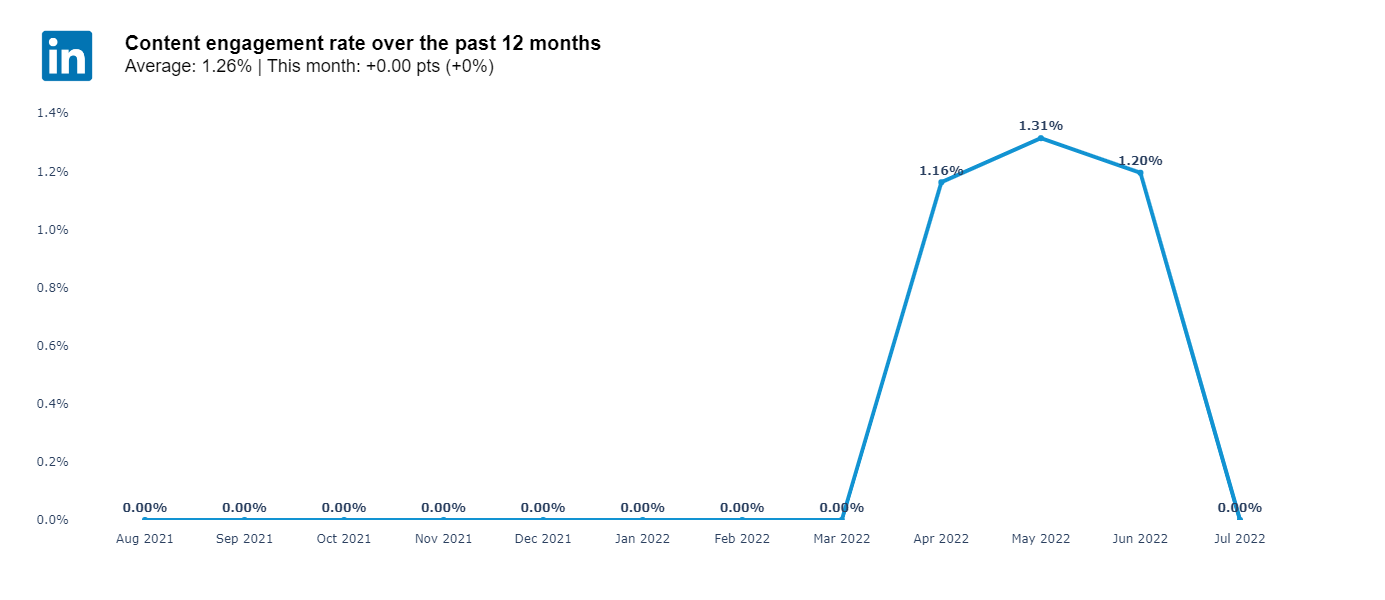

In [11]:
def create_linechart(df,
                    label="DATE_D",
                    value="VALUE",
                    value_d="VALUE_D",
                    text="TEXT"):
    # Init
    fig = go.Figure()
    
    # Create fig
    fig.add_trace(
        go.Scatter(
            x=df[label],
            y=df[value],
            mode="lines+markers+text",
            text=df[value_d],
            textposition="top center",
            hoverinfo="text",
            hovertext=df[text],
            line=dict(color=COLOR, width=4),
        )
    )
    # Add logo
    fig.add_layout_image(
        dict(
            source=LOGO,
            xref="paper",
            yref="paper",
            x=0.01,
            y=1.045,
            sizex=0.12,
            sizey=0.12,
            xanchor="right",
            yanchor="bottom"
        )
    )
    fig.update_traces(showlegend=False)
    # Plotly: Create title
    total_eng = df["ENGAGEMENTS"].sum()
    total_views = df["VIEWS"].sum()
    total_value = "{:,.2%}".format(total_eng / total_views).replace(",", " ")
    varv = df.loc[df.index[-1], "VARV"] * 100
    varp = df.loc[df.index[-1], "VARP"]
    varv_d = "{:,.2f} pts".format(varv).replace(",", " ")
    varp_d = "{:,.0%}".format(varp).replace(",", " ")
    if varv >= 0:
        varv_d = f"+{varv_d}"
        varp_d = f"+{varp_d}"
    title = f"<b><span style='font-size: 20px;'>{TITLE}</span></b><br><span style='font-size: 18px;'>Average: {total_value} | {PERIOD_TEXT}: {varv_d} ({varp_d})</span>"
    fig.update_layout(
        title=title,
        title_x=0.09,
        title_font=dict(family="Arial", color="black"),
        paper_bgcolor="#ffffff",
        plot_bgcolor="#ffffff",
        width=1200,
        height=600,
        margin_pad=10,
        yaxis = dict(
            range=[0, df[value].max() * 1.1],
            tickmode='array',
            tickformat='.1%'
        )
    )
    fig.show()
    return fig

fig = create_barchart(df_actual)

## Output

### Save and share your csv file

In [12]:
# Save your dataframe in CSV
output_path = save_graph_asset(df_actual, csv_output)

# Share output with naas
csv_link = naas.asset.add(output_path)

#-> Uncomment the line below to remove your asset
# naas.asset.delete(csv_output)

👌 Well done! Your Assets has been sent to production.



<IPython.core.display.Javascript object>

Button(button_style='primary', description='Copy URL', style=ButtonStyle())

Output()

PS: to remove the "Assets" feature, just replace .add by .delete


### Save and share your graph in HTML

In [13]:
# Save your graph in HTML
output_path = save_graph_asset(fig, html_output)

# Share output with naas
html_link = naas.asset.add(output_path, params={"inline": True})

#-> Uncomment the line below to remove your asset
# naas.asset.delete(html_output)

👌 Well done! Your Assets has been sent to production.



<IPython.core.display.Javascript object>

Button(button_style='primary', description='Copy URL', style=ButtonStyle())

Output()

PS: to remove the "Assets" feature, just replace .add by .delete


### Save and share your graph in image

In [14]:
# Save your graph in PNG
output_path = save_graph_asset(fig, image_output)

# Share output with naas
image_link = naas.asset.add(output_path)

#-> Uncomment the line below to remove your asset
# naas.asset.delete(image_output)

👌 Well done! Your Assets has been sent to production.



<IPython.core.display.Javascript object>

Button(button_style='primary', description='Copy URL', style=ButtonStyle())

Output()

PS: to remove the "Assets" feature, just replace .add by .delete


### Update Notion Report

In [15]:
df_actual["VALUE"] = round(df_actual["VALUE"] * 100, 2)
df_actual["VALUE_COMP"] = round(df_actual["VALUE_COMP"] * 100, 2)
df_actual["VARV"] = round(df_actual["VARV"] * 100, 2)
df_actual

,DATE,DATE_D,ENGAGEMENTS,VIEWS,VALUE,VALUE_COMP,VARV,VARP,VALUE_D,VARV_D,VARP_D,TEXT
0,2021-08,Aug 2021,0,0,0.00,0.00,0.00,0.000000,<b><span style=font-size: 16px; style=font-fam...,+0.00 pts,+0%,<b><span style='font-size: 14px;'>Aug 2021: <b...
1,2021-09,Sep 2021,0,0,0.00,0.00,0.00,0.000000,<b><span style=font-size: 16px; style=font-fam...,+0.00 pts,+0%,<b><span style='font-size: 14px;'>Sep 2021: <b...
2,2021-10,Oct 2021,0,0,0.00,0.00,0.00,0.000000,<b><span style=font-size: 16px; style=font-fam...,+0.00 pts,+0%,<b><span style='font-size: 14px;'>Oct 2021: <b...
3,2021-11,Nov 2021,0,0,0.00,0.00,0.00,0.000000,<b><span style=font-size: 16px; style=font-fam...,+0.00 pts,+0%,<b><span style='font-size: 14px;'>Nov 2021: <b...
4,2021-12,Dec 2021,0,0,0.00,0.00,0.00,0.000000,<b><span style=font-size: 16px; style=font-fam...,+0.00 pts,+0%,<b><span style='font-size: 14px;'>Dec 2021: <b...
5,2022-01,Jan 2022,0,0,0.00,0.00,0.00,0.000000,<b><span style=font-size: 16px; style=font-fam...,+0.00 pts,+0%,<b><span style='font-size: 14px;'>Jan 2022: <b...
6,2022-02,Feb 2022,0,0,0.00,0.00,0.00,0.000000,<b><span style=font-size: 16px; style=font-fam...,+0.00 pts,+0%,<b><span style='font-size: 14px;'>Feb 2022: <b...
7,2022-03,Mar 2022,0,0,0.00,0.00,0.00,0.000000,<b><span style=font-size: 16px; style=font-fam...,+0.00 pts,+0%,<b><span style='font-size: 14px;'>Mar 2022: <b...
8,2022-04,Apr 2022,35,3011,1.16,0.00,0.00,0.000000,<b><span style=font-size: 16px; style=font-fam...,+0.00 pts,+0%,<b><span style='font-size: 14px;'>Apr 2022: <b...
9,2022-05,May 2022,246,18720,1.31,1.16,0.15,0.130504,<b><span style=font-size: 16px; style=font-fam...,+0.15 pts,+13%,<b><span style='font-size: 14px;'>May 2022: <b...


In [16]:
update_report_status(KPI_TITLE,
                     PLATFORM,
                     OWNER,
                     df_actual,
                     image_link=image_link,
                     html_link=html_link,
                     csv_link=csv_link)

✅ Page 'Engagement rate - LinkedIn - Florent Ravenel' updated in Notion.
